# Try an InfoGAN on MNIST

In [1]:
%matplotlib inline
#Import a ton of stuff
import os
import struct
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from layers import Conv2d, ConvTranspose2d, Linear
from InfoGAN import InfoGAN

## Load the MNIST Data

In [2]:
# Load the MNIST CSV data from https://pjreddie.com/projects/mnist-in-csv/
# data_train = np.genfromtxt('./MNIST_Data/mnist_train.csv', delimiter = ',').astype(np.uint8)
# data_test = np.genfromtxt('./MNIST_Data/mnist_test.csv', delimiter = ',').astype(np.uint8)

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

data_train = read_idx('./MNIST_Data/train-images-idx3-ubyte')
data_test = read_idx('./MNIST_Data/t10k-images-idx3-ubyte')

targets_train = read_idx('./MNIST_Data/train-labels-idx1-ubyte')
targets_test = read_idx('./MNIST_Data/t10k-labels-idx1-ubyte')
print(data_train.shape, data_test.shape, targets_train.shape, targets_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [3]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.expand_dims(data_train, 1)
y_train = np.zeros((targets_train.shape[0], 10), dtype = np.uint8)
y_train[np.arange(targets_train.shape[0]), targets_train] = 1

x_test = np.expand_dims(data_test, 1)
y_test = np.zeros((data_test.shape[0], 10), dtype = np.uint8)
y_test[np.arange(targets_test.shape[0]), targets_test] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 2

[0 0 0 0 0 0 0 1 0 0]


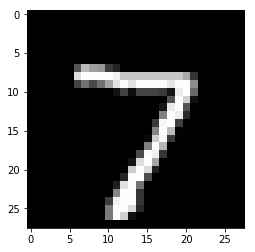

In [4]:
# Show an example from the test set
print(y_test[0])
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')

## PyTorch-ify our data and set the number of random samples we want to supervise with

In [5]:
supervision = 100 # Number of samples to supervise with

# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
shuffle_train = np.random.permutation(y_train.shape[0])
x_train_th = torch.from_numpy(x_train[shuffle_train])
y_train_th = torch.from_numpy(y_train[shuffle_train]).float()

x_test_th = torch.from_numpy(x_test)
y_test_th = torch.from_numpy(y_test)

# OK, we're going to be hacking this out. We'll multiply by the sum of the labels
# So to make this semisupervised, we set the labels we don't want to 0
y_train_th[int(supervision):] = 0

train_tensors = TensorDataset(x_train_th, y_train_th)
test_tensors = TensorDataset(x_test_th, y_test_th)
train_loader = DataLoader(train_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)

## Create our network
* c1_len is the length of the multinomial coding vector
* c2_len is the length of the Gaussian coding vector
* c3_len is the length of the Bernoulli coding vector. Note the original paper doesn't using any bernoulli codes
* z_len is the length of the noise vector
* embedding_len is  the length of the embedding output from the discriminator to compute the latent codes

In [6]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases

c1_len = 10 # Multinomial
c2_len = 2 # Gaussian
c3_len = 0 # Bernoulli
z_len = 64 # Noise vector length
embedding_len = 128

class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class ConvTranspose2d(nn.ConvTranspose2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Linear(z_len + c1_len + c2_len + c3_len, 1024)
        self.fc2 = Linear(1024, 7 * 7 * 128)

        self.convt1 = ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.convt2 = ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(7 * 7 * 128)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x))).view(-1, 128, 7, 7)

        x = F.relu(self.bn3(self.convt1(x)))
        x = self.convt2(x)

        return F.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1) # 28 x 28 -> 14 x 14
        self.conv2 = Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1) # 14 x 14 -> 7 x 7

        self.fc1 = Linear(128 * 7 ** 2, 1024)
        self.fc2 = Linear(1024, 1)
        self.fc1_q = Linear(1024, embedding_len)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn_q1 = nn.BatchNorm1d(embedding_len)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn1(self.conv2(x))).view(-1, 7 ** 2 * 128)

        x = F.leaky_relu(self.bn2(self.fc1(x)))
        return self.fc2(x), F.leaky_relu(self.bn_q1(self.fc1_q(x)))

In [7]:
# OK, now we create the actual models
gen = Generator().cuda()
dis = Discriminator().cuda()

In [8]:
# Link it all together into the InfoGAN. Also add the output layers for the latent codes
gan = InfoGAN(gen, dis, embedding_len, z_len, c1_len, c2_len, c3_len)

Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 1: 100%|| 60000/60000 [00:19<00:00, 3590.99it/s, loss_dis=0.181, loss_gen=0.608, loss_q=0.186]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 2: 100%|| 60000/60000 [00:18<00:00, 3757.59it/s, loss_dis=0.245, loss_gen=0.489, loss_q=0.112]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 3: 100%|| 60000/60000 [00:16<00:00, 3750.92it/s, loss_dis=0.305, loss_gen=0.463, loss_q=0.0734]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 4: 100%|| 60000/60000 [00:16<00:00, 3703.55it/s, loss_dis=0.369, loss_gen=0.426, loss_q=0.0677]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 5: 100%|| 60000/60000 [00:19<00:00, 3239.17it/s, loss_dis=0.306, loss_gen=0.442, loss_q=0.0413]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 6: 100%|| 60000/60000 [00:19<00:00, 3723.45it/s, loss_dis=0.355, loss_gen=0.464, loss_q=0.0617]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 7: 100%|| 60000/60000 [00:18<00:00, 2999.25it/s, loss_dis=0.275, loss_gen=0.512, loss_q=0.0281]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 8: 100%|| 60000/60000 [00:18<00:00, 3211.01it/s, loss_dis=0.344, loss_gen=0.469, loss_q=0.0337]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 9: 100%|| 60000/60000 [00:18<00:00, 3690.64it/s, loss_dis=0.267, loss_gen=0.558, loss_q=0.0529]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 10: 100%|| 60000/60000 [00:17<00:00, 3657.39it/s, loss_dis=0.388, loss_gen=0.477, loss_q=0.0242]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 11: 100%|| 60000/60000 [00:17<00:00, 3700.43it/s, loss_dis=0.37, loss_gen=0.418, loss_q=0.0384]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 12: 100%|| 60000/60000 [00:18<00:00, 3653.06it/s, loss_dis=0.277, loss_gen=0.591, loss_q=0.0532]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 13: 100%|| 60000/60000 [00:18<00:00, 3520.54it/s, loss_dis=0.19, loss_gen=0.827, loss_q=0.0274]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 14: 100%|| 60000/60000 [00:18<00:00, 3711.69it/s, loss_dis=0.169, loss_gen=0.78, loss_q=0.0616]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 15: 100%|| 60000/60000 [00:17<00:00, 3558.12it/s, loss_dis=0.184, loss_gen=0.751, loss_q=0.0377]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 16: 100%|| 60000/60000 [00:17<00:00, 3704.84it/s, loss_dis=0.203, loss_gen=0.658, loss_q=0.0265]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 17: 100%|| 60000/60000 [00:17<00:00, 3707.59it/s, loss_dis=0.156, loss_gen=0.619, loss_q=0.0779]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 18: 100%|| 60000/60000 [00:16<00:00, 3716.40it/s, loss_dis=0.143, loss_gen=0.644, loss_q=0.0588]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 19: 100%|| 60000/60000 [00:19<00:00, 3403.47it/s, loss_dis=0.122, loss_gen=0.748, loss_q=0.0281]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 20: 100%|| 60000/60000 [00:18<00:00, 3531.68it/s, loss_dis=0.155, loss_gen=0.869, loss_q=0.0187]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 21: 100%|| 60000/60000 [00:17<00:00, 3431.06it/s, loss_dis=0.123, loss_gen=0.823, loss_q=0.0227]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 22: 100%|| 60000/60000 [00:17<00:00, 3603.00it/s, loss_dis=0.125, loss_gen=0.642, loss_q=0.0228]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 23: 100%|| 60000/60000 [00:17<00:00, 3690.19it/s, loss_dis=0.141, loss_gen=0.821, loss_q=0.022]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 24: 100%|| 60000/60000 [00:16<00:00, 3688.82it/s, loss_dis=0.156, loss_gen=0.536, loss_q=0.0194]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 25: 100%|| 60000/60000 [00:16<00:00, 3704.37it/s, loss_dis=0.143, loss_gen=0.542, loss_q=0.0202]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 26: 100%|| 60000/60000 [00:17<00:00, 3361.37it/s, loss_dis=0.165, loss_gen=0.559, loss_q=0.0292]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 27: 100%|| 60000/60000 [00:19<00:00, 3244.65it/s, loss_dis=0.148, loss_gen=0.559, loss_q=0.0324]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 28: 100%|| 60000/60000 [00:18<00:00, 3633.39it/s, loss_dis=0.105, loss_gen=0.817, loss_q=0.0273]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 29: 100%|| 60000/60000 [00:17<00:00, 3430.36it/s, loss_dis=0.144, loss_gen=0.603, loss_q=0.0192]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 30: 100%|| 60000/60000 [00:17<00:00, 3043.04it/s, loss_dis=0.131, loss_gen=0.718, loss_q=0.0667]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 31: 100%|| 60000/60000 [00:18<00:00, 3450.36it/s, loss_dis=0.115, loss_gen=0.608, loss_q=0.0591]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 32: 100%|| 60000/60000 [00:18<00:00, 3443.58it/s, loss_dis=0.159, loss_gen=0.595, loss_q=0.041]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 33: 100%|| 60000/60000 [00:18<00:00, 3365.85it/s, loss_dis=0.215, loss_gen=0.492, loss_q=0.0177]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 34: 100%|| 60000/60000 [00:17<00:00, 3536.38it/s, loss_dis=0.108, loss_gen=0.717, loss_q=0.0233]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 35: 100%|| 60000/60000 [00:17<00:00, 3634.39it/s, loss_dis=0.231, loss_gen=0.466, loss_q=0.0321]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 36: 100%|| 60000/60000 [00:18<00:00, 3135.74it/s, loss_dis=0.106, loss_gen=0.861, loss_q=0.0239]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 37: 100%|| 60000/60000 [00:18<00:00, 3219.98it/s, loss_dis=0.151, loss_gen=0.654, loss_q=0.0213]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 38: 100%|| 60000/60000 [00:18<00:00, 3663.70it/s, loss_dis=0.133, loss_gen=0.657, loss_q=0.0227]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 39: 100%|| 60000/60000 [00:17<00:00, 3578.32it/s, loss_dis=0.112, loss_gen=0.665, loss_q=0.0241]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 40: 100%|| 60000/60000 [00:16<00:00, 3684.54it/s, loss_dis=0.161, loss_gen=0.911, loss_q=0.0228]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 41: 100%|| 60000/60000 [00:16<00:00, 3704.61it/s, loss_dis=0.106, loss_gen=0.852, loss_q=0.0209]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 42: 100%|| 60000/60000 [00:16<00:00, 3732.32it/s, loss_dis=0.117, loss_gen=0.838, loss_q=0.0216]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 43: 100%|| 60000/60000 [00:16<00:00, 3715.02it/s, loss_dis=0.148, loss_gen=0.571, loss_q=0.0201]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 44: 100%|| 60000/60000 [00:16<00:00, 3743.18it/s, loss_dis=0.114, loss_gen=0.661, loss_q=0.0254]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 45: 100%|| 60000/60000 [00:16<00:00, 3734.56it/s, loss_dis=0.112, loss_gen=0.755, loss_q=0.0231]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 46: 100%|| 60000/60000 [00:16<00:00, 3729.41it/s, loss_dis=0.103, loss_gen=0.819, loss_q=0.019]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 47: 100%|| 60000/60000 [00:16<00:00, 3715.48it/s, loss_dis=0.102, loss_gen=0.965, loss_q=0.0206]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 48: 100%|| 60000/60000 [00:16<00:00, 3631.93it/s, loss_dis=0.12, loss_gen=0.819, loss_q=0.0235]8]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 49: 100%|| 60000/60000 [00:16<00:00, 3711.58it/s, loss_dis=0.109, loss_gen=0.932, loss_q=0.0379]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 50: 100%|| 60000/60000 [00:16<00:00, 3720.43it/s, loss_dis=0.106, loss_gen=0.83, loss_q=0.0173]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 51: 100%|| 60000/60000 [00:16<00:00, 3664.92it/s, loss_dis=0.15, loss_gen=0.59, loss_q=0.0222]8]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 52: 100%|| 60000/60000 [00:16<00:00, 3671.40it/s, loss_dis=0.111, loss_gen=0.828, loss_q=0.0246]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 53: 100%|| 60000/60000 [00:16<00:00, 3694.62it/s, loss_dis=0.15, loss_gen=0.722, loss_q=0.0247]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 54: 100%|| 60000/60000 [00:16<00:00, 3705.88it/s, loss_dis=0.0776, loss_gen=0.876, loss_q=0.0224]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 55: 100%|| 60000/60000 [00:16<00:00, 3687.54it/s, loss_dis=0.137, loss_gen=0.743, loss_q=0.0192]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 56: 100%|| 60000/60000 [00:16<00:00, 3712.93it/s, loss_dis=0.12, loss_gen=0.763, loss_q=0.0172]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 57: 100%|| 60000/60000 [00:16<00:00, 3681.52it/s, loss_dis=0.097, loss_gen=1.01, loss_q=0.021]26]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 58: 100%|| 60000/60000 [00:16<00:00, 3698.79it/s, loss_dis=0.101, loss_gen=0.963, loss_q=0.0193]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 59: 100%|| 60000/60000 [00:16<00:00, 3696.47it/s, loss_dis=0.129, loss_gen=0.653, loss_q=0.0284]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 60: 100%|| 60000/60000 [00:16<00:00, 3729.96it/s, loss_dis=0.109, loss_gen=0.854, loss_q=0.0198]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 61: 100%|| 60000/60000 [00:16<00:00, 3706.56it/s, loss_dis=0.0851, loss_gen=0.885, loss_q=0.0193]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 62: 100%|| 60000/60000 [00:16<00:00, 3702.85it/s, loss_dis=0.135, loss_gen=1.04, loss_q=0.0207]]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 63: 100%|| 60000/60000 [00:16<00:00, 3678.61it/s, loss_dis=0.109, loss_gen=0.76, loss_q=0.0195]6]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 64: 100%|| 60000/60000 [00:16<00:00, 3692.89it/s, loss_dis=0.0769, loss_gen=0.765, loss_q=0.0302]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 65: 100%|| 60000/60000 [00:16<00:00, 3703.70it/s, loss_dis=0.0882, loss_gen=0.946, loss_q=0.0197]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 66: 100%|| 60000/60000 [00:16<00:00, 3720.39it/s, loss_dis=0.0763, loss_gen=0.996, loss_q=0.0228]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 67: 100%|| 60000/60000 [00:16<00:00, 3722.28it/s, loss_dis=0.103, loss_gen=0.741, loss_q=0.0437]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 68: 100%|| 60000/60000 [00:16<00:00, 3752.75it/s, loss_dis=0.0659, loss_gen=0.86, loss_q=0.0238]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 69: 100%|| 60000/60000 [00:16<00:00, 3726.41it/s, loss_dis=0.109, loss_gen=0.779, loss_q=0.0205]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 70: 100%|| 60000/60000 [00:16<00:00, 3710.05it/s, loss_dis=0.14, loss_gen=1.24, loss_q=0.0232]87]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 71: 100%|| 60000/60000 [00:16<00:00, 3722.06it/s, loss_dis=0.152, loss_gen=1.37, loss_q=0.0348]6]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 72: 100%|| 60000/60000 [00:16<00:00, 3755.20it/s, loss_dis=0.0847, loss_gen=1.09, loss_q=0.0215]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 73: 100%|| 60000/60000 [00:16<00:00, 3676.40it/s, loss_dis=0.0949, loss_gen=0.724, loss_q=0.0409]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 74: 100%|| 60000/60000 [00:16<00:00, 3701.19it/s, loss_dis=0.0731, loss_gen=0.841, loss_q=0.0216]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 75: 100%|| 60000/60000 [00:16<00:00, 3727.23it/s, loss_dis=0.0856, loss_gen=0.869, loss_q=0.0188]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 76: 100%|| 60000/60000 [00:16<00:00, 3742.99it/s, loss_dis=0.0796, loss_gen=1.24, loss_q=0.0232]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 77: 100%|| 60000/60000 [00:16<00:00, 3703.59it/s, loss_dis=0.165, loss_gen=1.03, loss_q=0.0233]8]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 78: 100%|| 60000/60000 [00:16<00:00, 3710.58it/s, loss_dis=0.11, loss_gen=1.07, loss_q=0.0322]9]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 79: 100%|| 60000/60000 [00:16<00:00, 3734.18it/s, loss_dis=0.105, loss_gen=0.831, loss_q=0.0172]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 80: 100%|| 60000/60000 [00:16<00:00, 3713.46it/s, loss_dis=0.0862, loss_gen=0.751, loss_q=0.0209]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 81: 100%|| 60000/60000 [00:16<00:00, 3715.09it/s, loss_dis=0.0701, loss_gen=1.04, loss_q=0.0187]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 82: 100%|| 60000/60000 [00:16<00:00, 3694.43it/s, loss_dis=0.0686, loss_gen=1.18, loss_q=0.0274]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 83: 100%|| 60000/60000 [00:18<00:00, 3362.92it/s, loss_dis=0.0828, loss_gen=0.721, loss_q=0.0215]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 84: 100%|| 60000/60000 [00:17<00:00, 3718.51it/s, loss_dis=0.139, loss_gen=0.626, loss_q=0.0395]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 85: 100%|| 60000/60000 [00:16<00:00, 3743.38it/s, loss_dis=0.08, loss_gen=0.885, loss_q=0.0272]2]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 86: 100%|| 60000/60000 [00:16<00:00, 3704.49it/s, loss_dis=0.074, loss_gen=0.801, loss_q=0.0186]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 87: 100%|| 60000/60000 [00:16<00:00, 3706.20it/s, loss_dis=0.0748, loss_gen=0.913, loss_q=0.0232]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 88: 100%|| 60000/60000 [00:16<00:00, 3751.83it/s, loss_dis=0.14, loss_gen=0.876, loss_q=0.0174]7]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 89: 100%|| 60000/60000 [00:16<00:00, 3699.98it/s, loss_dis=0.107, loss_gen=0.78, loss_q=0.0255]8]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 90: 100%|| 60000/60000 [00:16<00:00, 3703.59it/s, loss_dis=0.0797, loss_gen=0.719, loss_q=0.0679]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 91: 100%|| 60000/60000 [00:16<00:00, 3682.72it/s, loss_dis=0.11, loss_gen=0.757, loss_q=0.0292]3]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 92: 100%|| 60000/60000 [00:16<00:00, 3686.50it/s, loss_dis=0.114, loss_gen=0.642, loss_q=0.016]7]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 93: 100%|| 60000/60000 [00:16<00:00, 3659.89it/s, loss_dis=0.0933, loss_gen=0.696, loss_q=0.0211]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 94: 100%|| 60000/60000 [00:16<00:00, 3677.00it/s, loss_dis=0.0657, loss_gen=0.795, loss_q=0.018]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 95: 100%|| 60000/60000 [00:16<00:00, 3660.98it/s, loss_dis=0.0736, loss_gen=0.985, loss_q=0.0189]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 96: 100%|| 60000/60000 [00:16<00:00, 3705.48it/s, loss_dis=0.0748, loss_gen=0.894, loss_q=0.0644]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 97: 100%|| 60000/60000 [00:16<00:00, 3705.46it/s, loss_dis=0.0585, loss_gen=0.958, loss_q=0.018]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 98: 100%|| 60000/60000 [00:16<00:00, 3709.44it/s, loss_dis=0.084, loss_gen=0.917, loss_q=0.0363]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 99: 100%|| 60000/60000 [00:16<00:00, 3694.18it/s, loss_dis=0.0576, loss_gen=0.949, loss_q=0.018]]


Widget Javascript not detected.  It may not be installed or enabled properly.


60000/|/Epoch 100: 100%|| 60000/60000 [00:16<00:00, 3723.01it/s, loss_dis=0.0577, loss_gen=0.937, loss_q=0.0184]


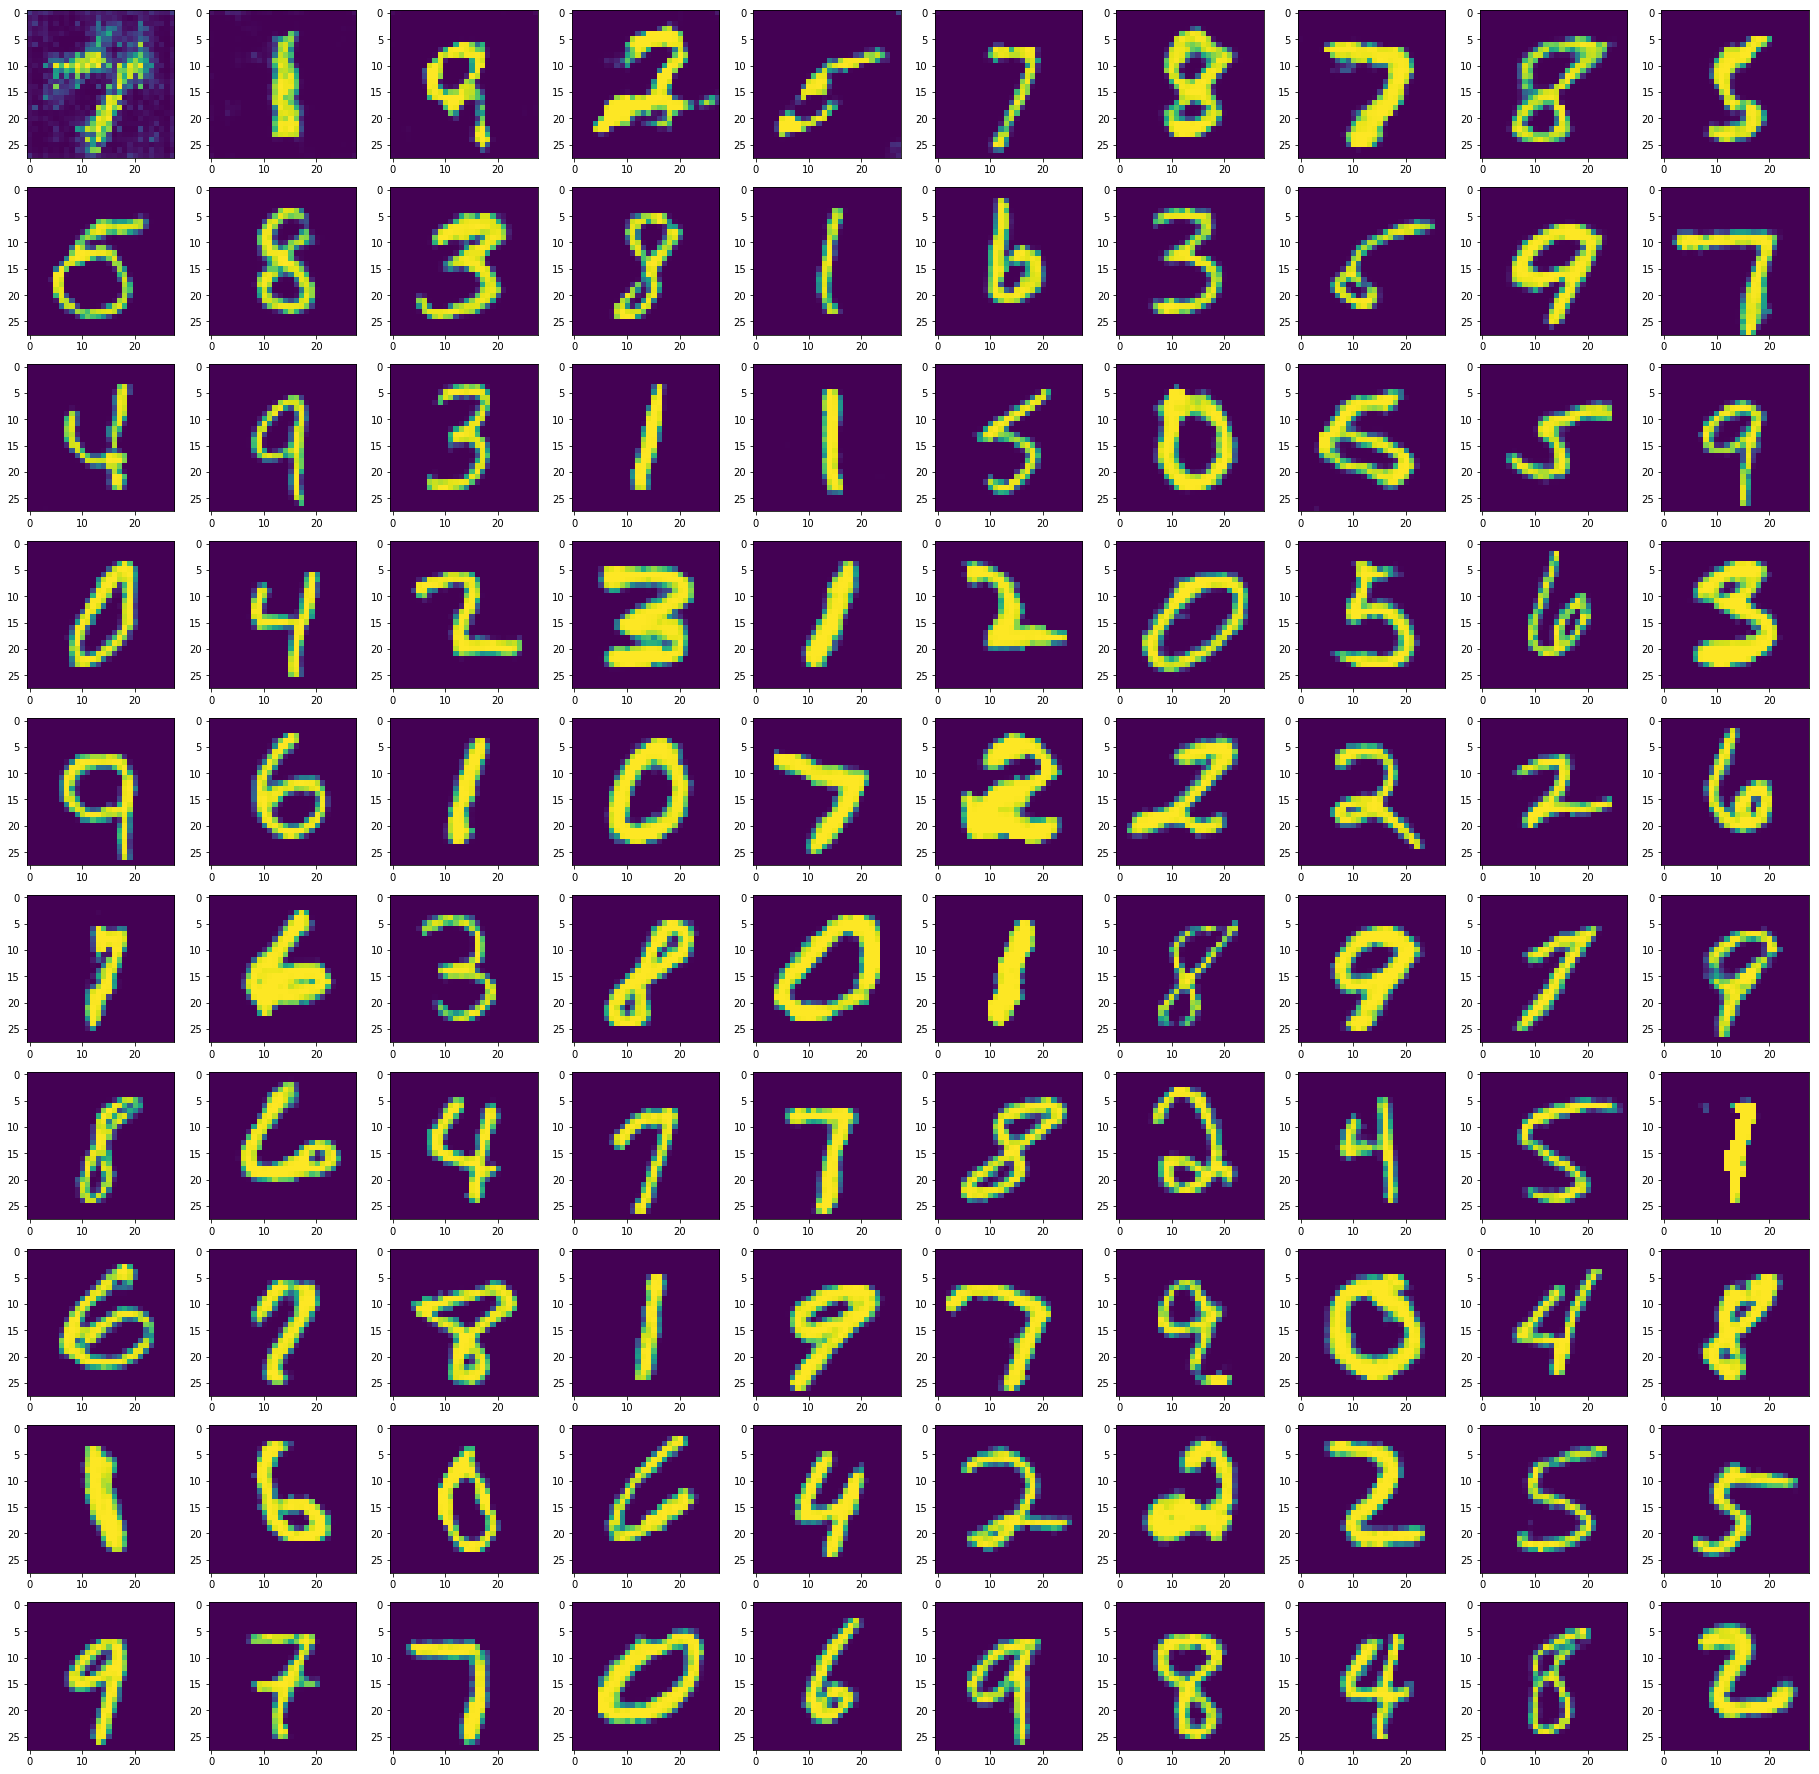

In [9]:
# Alright, everything's setup, let's run the GAN and train it
gan.train_all(train_loader)

In [10]:
gan.save('./mnist/')

In [11]:
gan.load('./mnist/')

## Display 10 digits from each multinomial coding vector possibility

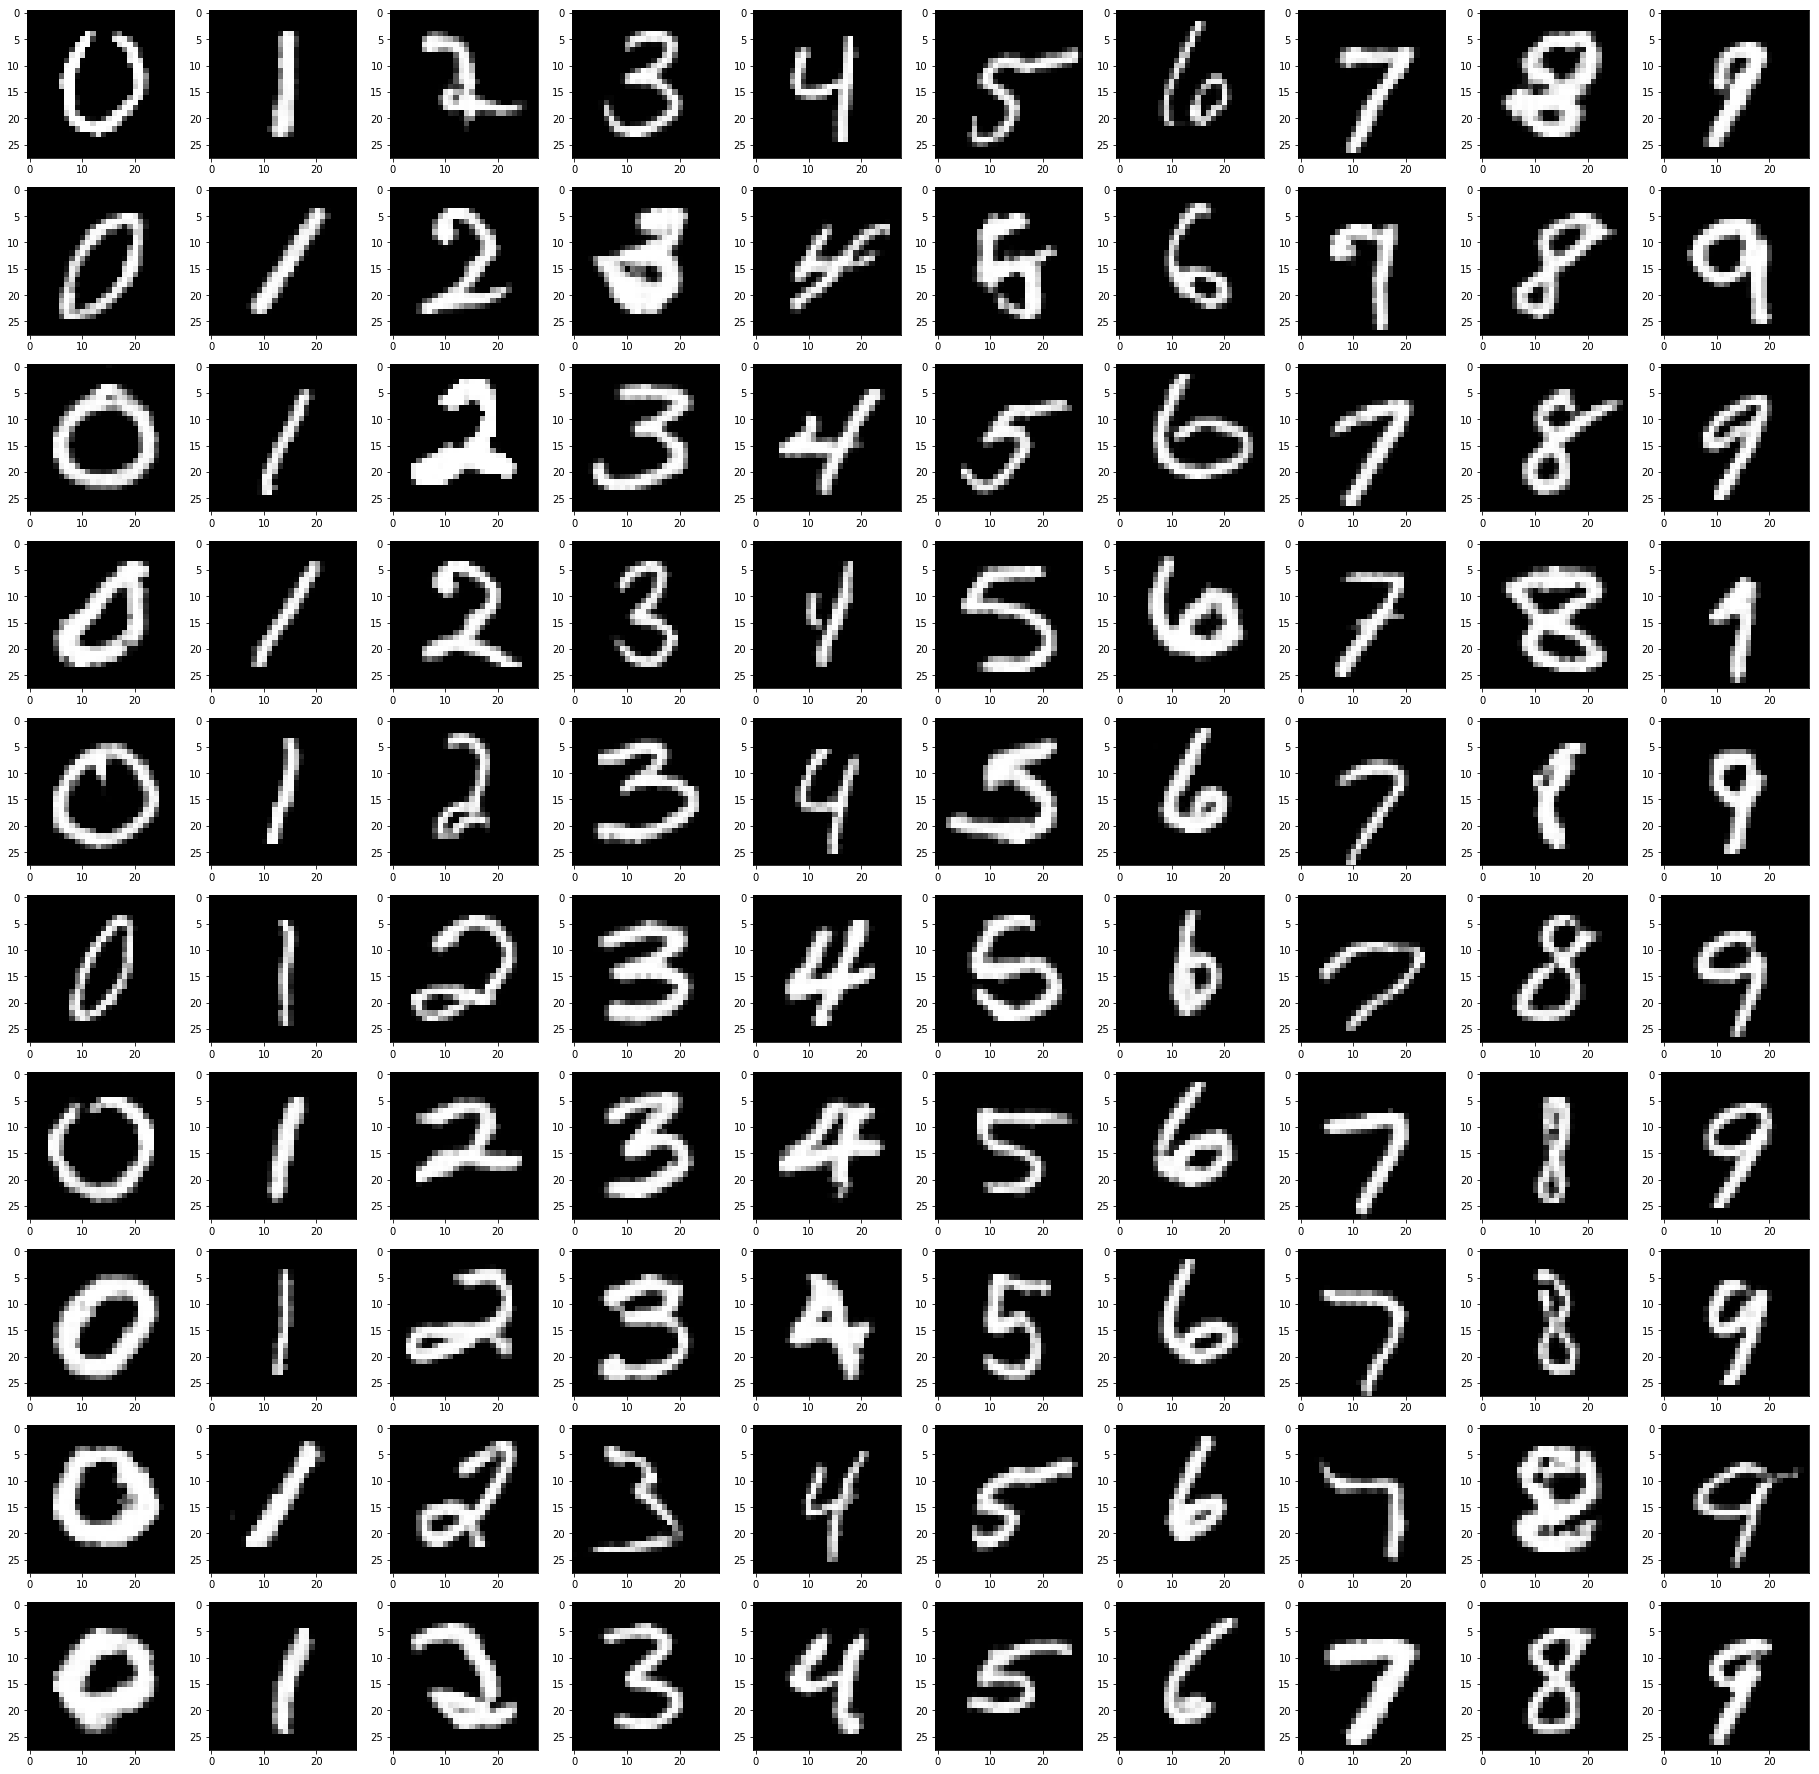

In [12]:
plt.figure(0, figsize = (32, 32))

z_dict = gan.get_z(c1_len * 10, sequential = True)
out_gen = gan.gen(torch.cat([z_dict[k] for k in z_dict.keys()], dim = 1))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(np.round(out_gen[idx - 1, 0].cpu().data.numpy() * 255), cmap = 'gray')

## Run our InfoGAN on the test set and see how good are the results. Only works for semisupervised InfoGAN

In [16]:
out_test = gan.run_dis(Variable(x_test_th).cuda().float() / 255)[1]
out_test = np.argmax(out_test.data.cpu().numpy(), axis = 1)

In [17]:
print(np.mean(out_test == np.argmax(y_test, axis = 1)))

0.9675
